In [23]:
import sys

import os

import matplotlib.pyplot as plt

import healpy as hp
 

In [2]:

pyilc_folder ='../'

sys.path.insert(1,pyilc_folder+'pyilc/')

from input import ILCInfo
from wavelets import Wavelets, wavelet_ILC, harmonic_ILC


In [3]:
# this file is where the preprocessed single-frequency maps will be downloaded and saved to.
# they take up about 2.2 Gb; feel free to change this location.

datafolder= pyilc_folder + 'data/' 

In [64]:
# here put the output folder where you want to save the output. 
# this will need to be able to hold ~70 GB.

output_folder = '/mnt/ceph/users/fmccarthy/pyilc_planck_tsz/standard_frequency_full/'
if not os.path.exists(output_folder):
    print("creating folder")
    os.makedirs(output_folder)
    
# a lot of the products are intermediate products that can be deleted afterwards
# eg by going to output_folder and doing "rm *_covmap_*" this will be reduced to ~40 GB
# Additionally doing "rm *_invcovmap*" IF you don't plan on making any more maps which requie
# the covmats (eg further deprojections) you can save most of the rest of the memory footprint

# Because of a quirk of the I/O structure of the maps, if you do "rm *_covmap_*"
# but not rm "*_invcovmap*"
# then you must explicitly add "inv_covmat_exist: 'true' " to future input .yml files 
# or else the covmats will get recompouted


In [6]:
def download_prepropressed_planckmaps(datafolder='../data/'):
    #in total these maps take up ~2 Gb
    !wget 'https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/inpainted_input_maps/full/30_full_1024.fits'
    !wget 'https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/inpainted_input_maps/full/44_full_1024.fits'
    !wget 'https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/inpainted_input_maps/full/70_full_1024.fits'
    !wget 'https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/inpainted_input_maps/full/100_full_2048.fits'
    !wget 'https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/inpainted_input_maps/full/143_full_2048.fits'
    !wget 'https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/inpainted_input_maps/full/217_full_2048.fits'
    !wget 'https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/inpainted_input_maps/full/353_full_2048.fits'
    !wget 'https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/inpainted_input_maps/full/545_full_2048.fits'
    !mv *.fits $datafolder 
    return 

In [7]:
download_prepropressed_planckmaps(datafolder=datafolder)

--2023-09-13 10:21:04--  https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/inpainted_input_maps/full/30_full_1024.fits
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 10.128.36.228
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|10.128.36.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100670400 (96M) [application/octet-stream]
Saving to: ‘30_full_1024.fits’

30_full_1024.fits   100%[===================>]  96.01M   304MB/s    in 0.3s    

2023-09-13 10:21:04 (304 MB/s) - ‘30_full_1024.fits’ saved [100670400/100670400]

--2023-09-13 10:21:04--  https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/inpainted_input_maps/full/44_full_1024.fits
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 10.128.36.228
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|10.128.36.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100670

In [8]:
def set_freqmapfiles_in_info(ILCInfo,datafolder='../data/'):

    for xind,x in enumerate([30,44,70,100,143,353,217,545]):
        if x<100:
            nside = 1024
        else:
            nside = 2048
        ILCInfo.freq_map_files[xind]= datafolder + str(x) + '_full_' + str(nside) +'.fits'

In [9]:
inputfile = pyilc_folder + 'input/sample_run_Planck_tsz_nodeproj.yml'

info = ILCInfo(inputfile)

set_freqmapfiles_in_info(info,datafolder)

info.output_dir = output_folder


In [14]:
output_folder

'/mnt/ceph/users/fmccarthy/pyilc_planck_tsz/standard_frequency_full/'

In [11]:
##########################
# read in frequency maps
info.read_maps()
# read in bandpasses
info.read_bandpasses()
# read in beams
info.read_beams()
#########################

In [12]:
# construct wavelets
wv = Wavelets(N_scales=info.N_scales, ELLMAX=info.ELLMAX, tol=1.e-6, taper_width=info.taper_width)
if info.wavelet_type == 'GaussianNeedlets':
    ell, filts = wv.GaussianNeedlets(FWHM_arcmin=info.GN_FWHM_arcmin)
elif info.wavelet_type == 'CosineNeedlets': # Fiona added CosineNeedlets
    ell,filts = wv.CosineNeedlets(ellmin = info.ellmin,ellpeaks = info.ellpeaks)
elif info.wavelet_type == 'TopHatHarmonic':
    ell,filts = wv.TopHatHarmonic(info.ellbins)
else:
    raise TypeError('unsupported wavelet type')

In [13]:
# wavelet ILC
# this takes some time if it has not been computed before!!
if info.wavelet_type == 'TopHatHarmonic':
    info.maps2alms()
    info.alms2cls()
    harmonic_ILC(wv, info, resp_tol=info.resp_tol, map_images=False)
else:
    wavelet_ILC(wv, info, resp_tol=info.resp_tol, map_images=False)



fwhms are [6.52444672 3.77034305 1.42505538 0.75406842 0.34906585 0.15932603
 0.11038431 0.0807931  0.0478692  0.01532402]
waveletizing frequency  0 ...
needlet coefficient map not previously computed; re-computing all maps for frequency 0 now...
done waveletizing frequency  0 ...
waveletizing frequency  1 ...
needlet coefficient map not previously computed; re-computing all maps for frequency 1 now...
done waveletizing frequency  1 ...
waveletizing frequency  2 ...
needlet coefficient map not previously computed; re-computing all maps for frequency 2 now...
done waveletizing frequency  2 ...
waveletizing frequency  3 ...
needlet coefficient map not previously computed; re-computing all maps for frequency 3 now...
done waveletizing frequency  3 ...
waveletizing frequency  4 ...
needlet coefficient map not previously computed; re-computing all maps for frequency 4 now...
done waveletizing frequency  4 ...
waveletizing frequency  5 ...
needlet coefficient map not previously computed; re-

done computing all covariance maps at scale0
needlet coefficient inverse covariance map not previously computed; re-computing all inverse covariance maps at scale 0 now...
in compute weights at scale
done computing all inverse covariance maps at scale0
done computing all ILC weights at scale0
needlet coefficient covariance map not previously computed; re-computing all covariance maps at scale 1 now...
done computing all covariance maps at scale1
needlet coefficient inverse covariance map not previously computed; re-computing all inverse covariance maps at scale 1 now...
in compute weights at scale
done computing all inverse covariance maps at scale1
done computing all ILC weights at scale1
needlet coefficient covariance map not previously computed; re-computing all covariance maps at scale 2 now...
done computing all covariance maps at scale2
needlet coefficient inverse covariance map not previously computed; re-computing all inverse covariance maps at scale 2 now...
in compute weights

In [58]:
import wavelets
_ILC_map_filename = wavelets._ILC_map_filename(info)
ymap = hp.fitsfunc.read_map(ILC_map_filename)

'/mnt/ceph/users/fmccarthy/pyilc_planck_tsz/standard_frequency_full/needletILCmap_component_tSZ.fits'

In [43]:
def download_preproprecessing_mask(datafolder='../data/'):
    !wget 'https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/masks/LFI_inpainting_bool.fits'
    !wget 'https://users.flatironinstitute.org/~fmccarthy/ymaps_PR4_McCH23/masks/HFI_inpainting_bool.fits'
    !mv *.fits $datafolder 
    return 

#download_preproprecessing_mask(datafolder)
LFImask = hp.fitsfunc.read_map(datafolder+'LFI_inpainting_bool.fits')
HFImask = hp.fitsfunc.read_map(datafolder+'HFI_inpainting_bool.fits')
preprocessing_mask = LFImask*HFImask

In [59]:
%matplotlib inline

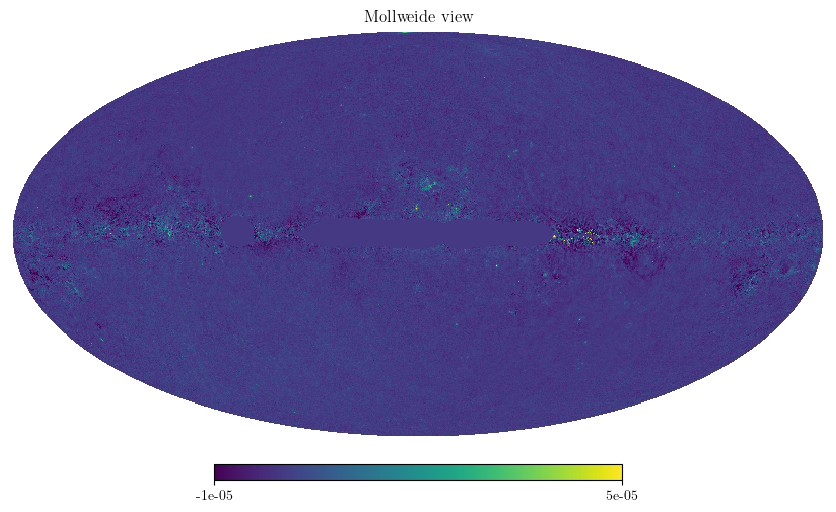

In [61]:
hp.mollview(preprocessing_mask*ymap,min=-1e-5,max=5e-5)

In [63]:
info.output_dir

'/mnt/ceph/users/fmccarthy/pyilc_planck_tsz/standard_frequency_full/'